In [191]:
import numpy as np
import pandas as pd
from numba import njit, float64

from math import ceil
from scipy.stats import norm
import scipy.stats as stats
from scipy.stats import qmc

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm, trange

plt.rcParams["figure.figsize"] = (20, 7)
plt.rcParams["font.size"] = 13
plt.style.use('bmh')

import json

# Question 4: Pricing 2 step Asian Options using Monte Carlo
Write a Monte Carlo simulation program that generates n = 106 samples1
(under the probability measure Q) of the payoff CT . The program should produce a Monte
Carlo estimate  ̄C0 of C0, the standard error in that estimate, and a 95% confidence interval
based on that standard error. Compare the result to the theoretical value you found in the
previous question

In [192]:
# Parameters
T       = 10 # Years
r       = -0.0027 #np.log(1-0.0027)
sigma   = 0.21
S       = K = 715

CI95 = norm.ppf(1-(.05/2)) ; print(f'CI95 = {CI95:.4f}')

CI95 = 1.9600


**Analytical Solutions to calculate the Discounted Expected Payoff of 2 step Asian Put (Geometric Mean). Where:**
$$
C_0 = e^{-rT}E^{Q}[(K - S_{0}exp\{aT+bdW_T\})^{+}]
$$

**Under Risk Neutral Probability**
$$
\begin{align*}
&a &=\;& \frac{1}{2}(r+\frac{1}{2}\sigma^2) \\
&b &=\;& \frac{1}{3}\sigma\sqrt{\frac{5}{2}} \\
\end{align*}
$$

**Calculating $C_0$ Analytically:**
$$
\begin{align*}
 & C_0 &=\;& e^{-rT}[K\Phi(d) - S_0\cdot exp\{aT+\frac{1}{2}b^2T\}\Phi(d-b\sqrt{T})] \\
 & d   &=\;& \frac{ln(K/S_0) - aT}{b\sqrt{T}}
\end{align*}
$$

In [193]:
def asian_2_step_put_analytical(S0, K, r, sigma, T):
    a = 0.5*(r-.5*sigma**2)
    b = 1/3*sigma*np.sqrt(5/2)

    d = (np.log(K/S0) - a*T) / (b*np.sqrt(T))

    P = np.exp(-r*T) * (K*norm.cdf(d) - S0*np.exp(a*T + 0.5* b**2 * T) * norm.cdf(d-b*np.sqrt(T)))
    return P
    

In [194]:
def asian_2_step_put_MC(S0, K, r, sigma, T, n_paths):
    dt = T/2
    # W: Weiner Process with iid Normal variables with std=sqrt(dt)
    W       = np.random.normal(loc=0., scale=np.sqrt(dt), size=(n_paths,2) )
    
    S1 = S0 * np.exp((r-.5*sigma**2)*dt + sigma*W[:,0])
    S2 = S1 * np.exp((r-.5*sigma**2)*dt + sigma*W[:,1])
    HT = np.power(S0*S1*S2, 1/3)

    Payoffs = np.maximum(K - HT, 0) * np.exp(-r*T)
    P  = Payoffs.mean()  # Numerical Approximation of the Put's Value
    SE = Payoffs.std(ddof=1) / np.sqrt(n_paths) # Calculating Standard Error
    return P, SE
    
    
n_paths = 10**6

analytical_result           = asian_2_step_put_analytical(S, K, r, sigma, T)
numerical_approximation, SE = asian_2_step_put_MC(S, K, r, sigma, T, n_paths)

print(f'Analytical  = {asian_2_step_put_analytical(S, K, r, sigma, T):.3f}')
print(f'Monte-Carlo = {numerical_approximation:.3f} ,  Number of paths = {n_paths:,}')
print(f'SE = {SE:.3f}')
print(f'RE = {SE/numerical_approximation*100:.3f} %')
print(f'95% CI = [{numerical_approximation - SE*CI95:.3f} , {numerical_approximation + SE*CI95:.3f}]')
print(f'\nTime to calculate put Value using Monte Carlo:')
%timeit asian_2_step_put_MC(S, K, r, sigma, T, n_paths)

Analytical  = 122.765
Monte-Carlo = 122.575 ,  Number of paths = 1,000,000
SE = 0.131
RE = 0.107 %
95% CI = [122.319 , 122.831]

Time to calculate put Value using Monte Carlo:
62 ms ± 2.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Question 5: Asian Put
Write a Monte Carlo simulation program that generates n = 104 samples1
(under the probability measure Q) of the stock price path and the payoff GT . Use this to
generate a Monte Carlo estimate  ̄G0 of the price G0, the standard error in that estimate,
and a 95% confidence interval based on that standard error

In [195]:
""" MC approximation of Asian """
def asian_put_MC(S0, K, r, sigma, T, N, M):
    dt      = T/M
    Payoffs = np.empty(shape=N)
    
    drift   = (r - 0.5*sigma**2)*dt
    volatil = sigma*np.sqrt(dt)
    X       = np.random.normal(loc=drift, scale=volatil, size=(N, M))
    
    # loop over paths
    for m in range(N):
        # Mean St Value
        St = np.mean(S0 * np.exp(np.cumsum(X[m])))
        # Payoff
        Payoffs[m] = np.maximum(K - St, 0) * np.exp(-r*T)

    P  = Payoffs.mean()  # Numerical Approximation of the Put's Value
    SE = Payoffs.std() / np.sqrt(N) # Calculating Standard Error
    return P, SE


_n_paths    = 10**4 ;   M = 100
numerical_approximation, SE = asian_put_MC(S, K, r, sigma, T, _n_paths, M)

print(f'Monte-Carlo = {numerical_approximation:.3f} ,  Number of paths = {_n_paths:,}')
print(f'SE = {SE:.3f}')
print(f'RE = {SE/numerical_approximation*100:.3f} %')
print(f'95% CI = [{numerical_approximation - SE*CI95:.3f} , {numerical_approximation + SE*CI95:.3f}]')
print(f'\nTime to calculate put Value using Monte Carlo')

%timeit asian_put_MC(S, K, r, sigma, T, _n_paths, M)

Monte-Carlo = 116.117 ,  Number of paths = 10,000
SE = 1.296
RE = 1.116 %
95% CI = [113.577 , 118.657]

Time to calculate put Value using Monte Carlo
84.9 ms ± 633 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Question 6 - Control Variates in Pricing Asian Options
Repeat the calculation in 5. but this time use the payoffs CT in (1) as a control
variate: take the n = 104 samples of the stock price path you generated to define a new
estimator based on
Gnew
T = GT − βCT ,
and then add βC0 afterwards, as indicated in Lecture 4. To make an appropriate choice
for β, use your samples {(Gi
T , Ci
T ), i = 1...104}. Report the value, standard error, and the
95% confidence interval for  ̄Gnew
0 and compare your result to the values you found in 5

Using the 2 step Asian Put as a control variate for reducing the variance in the estimation of the value of an Asian Option.
$$
\begin{align*}
 & G_{new}  &=\;& G_0 - c*(C_0 - C_{Analytical}) \\
 &c         &=\;& \frac{Cov(G_0, C_0)}{Var(C_0)} \\
\end{align*}
$$
Average c ~ 0.92

In [196]:
def asian_put_MC_CV(S0, K, r, sigma, T, N, M):
    analytical_2_step_asian = asian_2_step_put_analytical(S0, K, r, sigma, T)
    dt      = T/M
    Payoffs = np.empty(shape=(N,2))
    
    drift   = (r - 0.5*sigma**2)*dt
    volatil = sigma*np.sqrt(dt)
    X       = np.random.normal(loc=drift, scale=volatil, size=(N, M)) # paths x time_increments

    for m in range(N):
        St = S0 * np.exp(np.cumsum(X[m]))
        
        """ 2 Step Asian Option """
        HT = np.cbrt(St[0] * St[int(M/2)]* St[-1])
        
        Payoffs[m, 0] = np.maximum(K - HT, 0)

        """ Asian Option """
        Payoffs[m, 1] =  np.maximum(K - np.mean(St), 0)

    Payoffs *= np.exp(-r*T)

    """ Calculating Control Variates """
    c = (np.cov(m=Payoffs[:, 1], y=Payoffs[:, 0])[0, 1])/Payoffs[:, 0].var() ;   # print(f'c = {c}')

    """ Adjusting Results Using Control Variates """
    Payoffs_adj = Payoffs[:,1] - c*(Payoffs[:, 0] - analytical_2_step_asian)

    P   = Payoffs_adj.mean()
    SE  = Payoffs_adj.std() / np.sqrt(N)
    return P, SE

n_paths = 10**4 ;   M = 100
asian_CV_numerical_result, SE = asian_put_MC_CV(S, K, r, sigma, T, n_paths, M)

print(f'MC = {asian_CV_numerical_result:.3f} ,  Number of samples = {n_paths:,}')
print(f'SE = {SE:.3f}')
print(f'RE = {SE/asian_CV_numerical_result*100:.3f} %')
print(f'95% CI = [{asian_CV_numerical_result - SE*CI95:.3f} , {asian_CV_numerical_result + SE*CI95:.3f}]')
print(f'\nTime to calculate put Value using Monte Carlo')

%timeit asian_put_MC_CV(S, K, r, sigma, T, n_paths, M)

MC = 114.829 ,  Number of samples = 10,000
SE = 0.460
RE = 0.401 %
95% CI = [113.927 , 115.731]

Time to calculate put Value using Monte Carlo
102 ms ± 2.72 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Extra: Sobol MC - C Compiled Python numba
**Reduce variance of the estimation:**
- Sobol MC: Sobol’ sequences (also called LPτ sequences or (t, s) sequences in base 2) are an example of quasi-random low-discrepancy sequences
    
**Reduce Computation time:**
- Numba: Just in time (JIT) Compiler allows python/numpy funcitons to be compiled to opimized C code before execution and cashed for future use. This speeds up sertain tasks 100-1000X times.


In [197]:
# Sobol - Quasi Monte Carlo for path simulation
def sobol_norm(m, d=1 ,seed=1234):
    sampler = qmc.Sobol(d, scramble=True, seed=seed)
    x_sobol = sampler.random_base2(m)
    return stats.norm.ppf(x_sobol)

@njit
def asian_put_MC_CV(S0, K, r, sigma, T, N, M, X, analytical):
    Payoffs = np.empty(shape=(N,2))

    for m in range(N):
        St = S0 * np.exp(np.cumsum(X[m]))
        
        """ 2 Step Asian Option """
        HT = np.cbrt(St[0] * St[int(M/2)]* St[-1])
        
        Payoffs[m, 0] = np.maximum(K - HT, 0)

        """ Asian Option """
        Payoffs[m, 1] =  np.maximum(K - np.mean(St), 0)

    Payoffs *= np.exp(-r*T)

    """ Calculating Control Variates """
    c = (np.cov(m=Payoffs[:, 1], y=Payoffs[:, 0])[0, 1])/Payoffs[:, 0].var() ;   # print(f'c = {c}')

    """ Adjusting Results Using Control Variates """
    Payoffs_adj = Payoffs[:,1] - c*(Payoffs[:, 0] - analytical)

    P   = Payoffs_adj.mean()
    SE  = Payoffs_adj.std() / np.sqrt(N)
    return P, SE

n_paths = ceil(np.log2(10**4)) ;   M = 100

analytical_2_step_asian = asian_2_step_put_analytical(S, K, r, sigma, T)
dt      = T/M

drift   = (r - 0.5*sigma**2)*dt
volatil = sigma*np.sqrt(dt)
W       = sobol_norm(n_paths, d=M, seed=1235)
X       = drift + volatil*W

asian_CV_numerical_result, SE = asian_put_MC_CV(S, K, r, sigma, T, 2**n_paths, M, X, analytical_2_step_asian)

print(f'MC = {asian_CV_numerical_result:.3f} ,  Number of samples = {2**n_paths:,}')
print(f'SE = {SE:.3f}')
print(f'RE = {SE/asian_CV_numerical_result*100:.3f} %')
print(f'95% CI = [{asian_CV_numerical_result - SE*CI95:.3f} , {asian_CV_numerical_result + SE*CI95:.3f}]')
print(f'\nTime to calculate put Value using Monte Carlo')

# %timeit asian_put_MC_CV(S, K, r, sigma, T, n_paths, M, X, analytical_2_step_asian)

MC = 114.705 ,  Number of samples = 16,384
SE = 0.360
RE = 0.314 %
95% CI = [113.999 , 115.411]

Time to calculate put Value using Monte Carlo


# Extra: Greeks

In [198]:
from importlib import reload
import Asian_Option_Pricing as ao
reload(ao)

AP = ao.Asian_Put_Option(S=S, K=K, T=9, r=r, sigma=sigma)
P0, SE = AP.get_price(number_of_paths=10**5)
print(f'Price of Asian Put : {P0:.5f} USD')
print(f'Standard Error     : {SE:.5f} USD')
print('\n Greeks:\n------------------------')
print(f'Delta   : {AP.Delta :.5f}')
print(f'Vega    : {AP.Vega  :.3f}')
print(f'Theta   : {AP.Theta :.3f}')
print(f'Rho     : {AP.Rho :.3f}')
print(f'Gamma   : {AP.Gamma :.5f}')

Price of Asian Put : 108.46036 USD
Standard Error     : 0.00000 USD

 Greeks:
------------------------
-0.45705531633240587
Delta   : -0.45706
Vega    : 486.350
Theta   : 6.403
Rho     : -2340.218
Gamma   : 0.00164


# Hedgins Simulation - Work in Progress

In [199]:
S = 10
K = 10
r = 0.05
sigma = 0.4
T = 1

# Todo Add St History


Number of timesteps: 201
-0.39791145807894
P0    : 0.77 EUR 
Delta : -0.39791 Stock


  0%|          | 0/19 [00:00<?, ?it/s]

t : 0.05 
t_index : 0.05
-0.23178490426701495
t : 0.1 
t_index : 0.1
-0.28735743704302724
t : 0.15000000000000002 
t_index : 0.15
-0.27334407704696523
t : 0.2 
t_index : 0.2
-0.21845182436867347
t : 0.25 
t_index : 0.25
-0.2698772570513347
t : 0.3 
t_index : 0.3
-0.13055687002994343
t : 0.35000000000000003 
t_index : 0.35000000000000003
-0.08873829256054501
t : 0.4 
t_index : 0.4
-0.07387887246300308
t : 0.45 
t_index : 0.45
-0.21862276462727598
t : 0.5 
t_index : 0.5
-0.29296115548154456
t : 0.55 
t_index : 0.55
-0.2312940381026323
t : 0.6000000000000001 
t_index : 0.6
-0.23040367499159062
t : 0.6500000000000001 
t_index : 0.65
-0.3047122704069823
t : 0.7000000000000001 
t_index : 0.7000000000000001
-0.35349844394433255
t : 0.7500000000000001 
t_index : 0.75
-0.09689166467464098
t : 0.8 
t_index : 0.8
-0.25536855282463794
t : 0.8500000000000001 
t_index : 0.85
-0.12685297657386957
t : 0.9000000000000001 
t_index : 0.9
-0.0689031037814964
t : 0.9500000000000001 
t_index : 0.95000000000

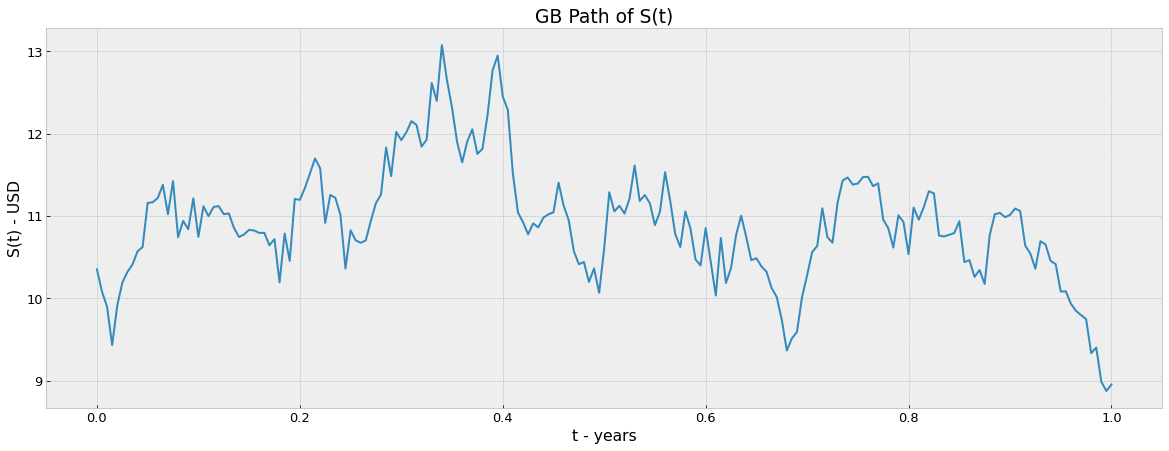

In [200]:
reload(ao)

# GBM Path
dt = 1/200
mu = .08
rehedging_frequency = 1/20

_number_of_timesteps = int(T/dt) +1   ;   print(f'Number of timesteps: {_number_of_timesteps}')
X       = np.random.normal(loc=mu*dt, scale=sigma*np.sqrt(dt), size=_number_of_timesteps) 
S_path  = S * np.exp(np.cumsum(X))

# Plot Path
S_series = pd.Series(S_path, index=np.linspace(0, T, _number_of_timesteps))
S_series.plot(title='GB Path of S(t)', ylabel='S(t) - USD', xlabel='t - years')

# T = 0
AP = ao.Asian_Put_Option(S=S, K=K, T=T, r=r, sigma=sigma)
P0 = AP.get_price()[0]

Delta       = AP.Delta
print(f'P0    : {P0:.2f} EUR \nDelta : {Delta:.5f} Stock')
Portfolio   = {0 : [Delta, (Delta*S)*np.exp(r*T)]}

# Function to find the nearest index of t in 
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

# Loop over time to simulate the rebalancing of the replicating portfolio
for t in tqdm(np.arange(rehedging_frequency, T, rehedging_frequency)):
    t_index = find_nearest(S_series.index, value=t)
    print(f't : {t} \nt_index : {t_index}')
    _S = S_series[t_index]

    AP = ao.Asian_Put_Option(S=_S, K=K, T=T-t_index, r=r, sigma=sigma, _greek=True)
    Delta       = AP.Delta

    previous_Delta = list(Portfolio.values())[-1][0]

    Portfolio[t_index] = [Delta, (Delta - previous_Delta)*_S * np.exp(r*(T-t_index))]
    # print(Portfolio.values()) ; break

    # if t> 1 : 
    #     print(f'\nPortfolio:')
    #     print(json.dumps(Portfolio, indent=2))
    #     break

RP_df = pd.DataFrame.from_dict(Portfolio, orient='index', columns=['Delta', 'Balance'])

Total_Balance = P0*np.exp(r*T) + -RP_df.Balance.sum() + RP_df.Delta.values[-1]*S_series.values[-1]
print(f'Total Balance: {Total_Balance}')


In [201]:
P0*np.exp(r*T) ,RP_df.Balance.sum() ,-RP_df.Delta.values[-1]*S_series.values[-1]

(0.8063347671310968, -3.0833514104503292, 3.412974859155275)

In [202]:
RP_df

,Delta,Balance
0.00,-0.397911,-4.183128
0.05,-0.231785,1.943810
0.10,-0.287357,-0.624641
0.15,-0.273344,0.158382
0.20,-0.218452,0.639641
0.25,-0.269877,-0.577990
0.30,-0.130557,1.719916
0.35,-0.088738,0.532066
0.40,-0.073879,0.190647
0.45,-0.218623,-1.643174
